# Aligning single-cell resolution spatial transcriptomics data to  H&E staining image from Visium

In this notebook, we take a single cell resolution spatial transcriptomics datasets of a coronal section of the adult mouse brain profiled by the MERFISH technology and align it to a H&E staining image from a different individual at matched locations with respect to bregma. 

We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [1]:
## import dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd
import torch
import plotly
import requests

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [2]:
## skip cell if STalign.py in same folder as notebook
import sys
sys.path.append("../../STalign") 

In [3]:
## import STalign from upper directory
import STalign

We can read in the single cell information using `pandas` as `pd`.

In [4]:
# Single cell data 1
# read in data
fname = '../merfish_data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

                                Unnamed: 0  fov       volume    center_x  \
0  158338042824236264719696604356349910479   33   532.778772  617.916619   
1  260594727341160372355976405428092853003   33  1004.430016  596.808018   
2  307643940700812339199503248604719950662   33  1267.183208  578.880018   
3   30863303465976316429997331474071348973   33  1403.401822  572.616017   
4  313162718584097621688679244357302162401   33   507.949497  608.364018   

      center_y       min_x       max_x        min_y        max_y  
0  2666.520010  614.725219  621.108019  2657.545209  2675.494810  
1  2763.450012  589.669218  603.946818  2757.013212  2769.886812  
2  2748.978012  570.877217  586.882818  2740.489211  2757.466812  
3  2766.690012  564.937217  580.294818  2756.581212  2776.798812  
4  2687.418010  603.061218  613.666818  2682.493210  2692.342810  


For alignment with `STalign`, we only need the cell centroid information. So we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

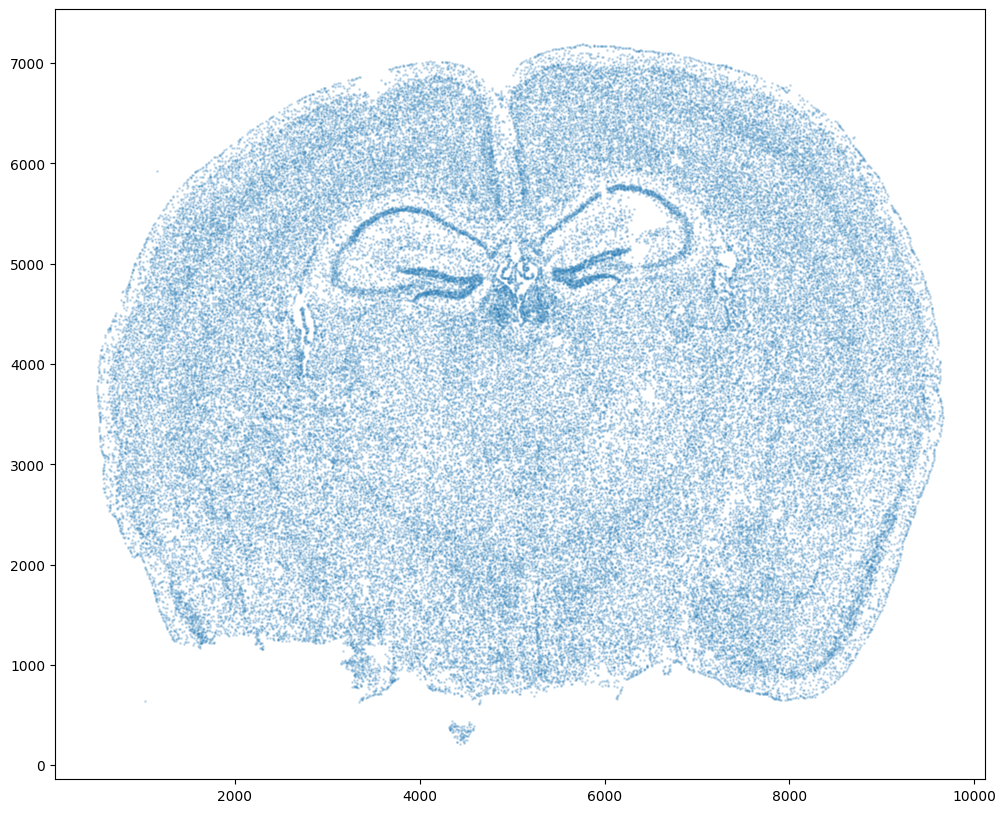

In [5]:
# get cell centroid coordinates
xI = np.array(df1['center_x'])
yI = np.array(df1['center_y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)
#ax.set_aspect('equal', 'box')

We will use STalign to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency.

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


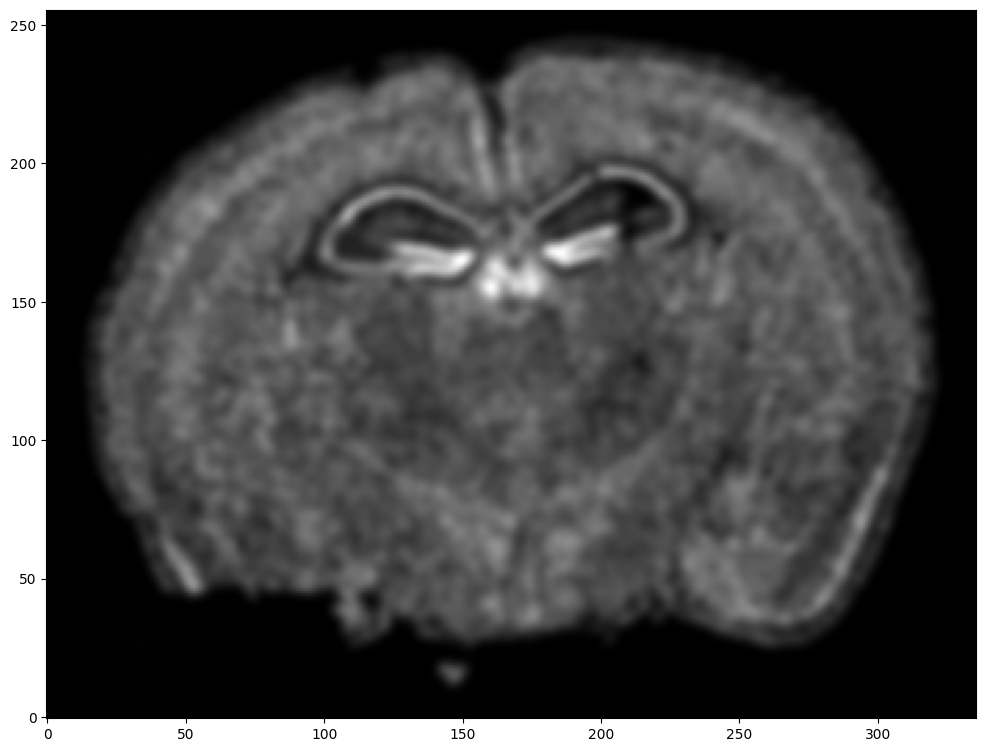

In [6]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XI,YI,I,fig = STalign.rasterize(xI, yI, dx=30)

ax = fig.axes[0]
ax.invert_yaxis()

Note that this is a 1D greyscale image. To align with an RGB H&E image, we will need to make our greyscale image into RGB by simply stacking the 1D values 3 times. We will also normalize to get intensity values between 0 to 1.

In [7]:
print("The initial shape of I is {}".format(I.shape))
I = np.vstack((I, I, I)) # make into 3xNxM
print("The range of I is {} to {}".format(I.min(), I.max() ))

# normalize
I = STalign.normalize(I)
print("The range of I after normalization is {} to {}".format(I.min(), I.max() ))

# double check size of things
print("The new shape of I is {}".format(I.shape))

The initial shape of I is (1, 256, 336)
The range of I is 0.0 to 4.715485184477206
The range of I after normalization is 0.0 to 1.0
The new shape of I is (3, 256, 336)


We have already downloaded the H&E staining image from https://www.10xgenomics.com/resources/datasets/adult-mouse-brain-ffpe-1-standard-1-3-0 and placed the file in a folder called `visium_data`

We can read in the H&E staining image using `matplotlib.pyplot` as `plt`. 

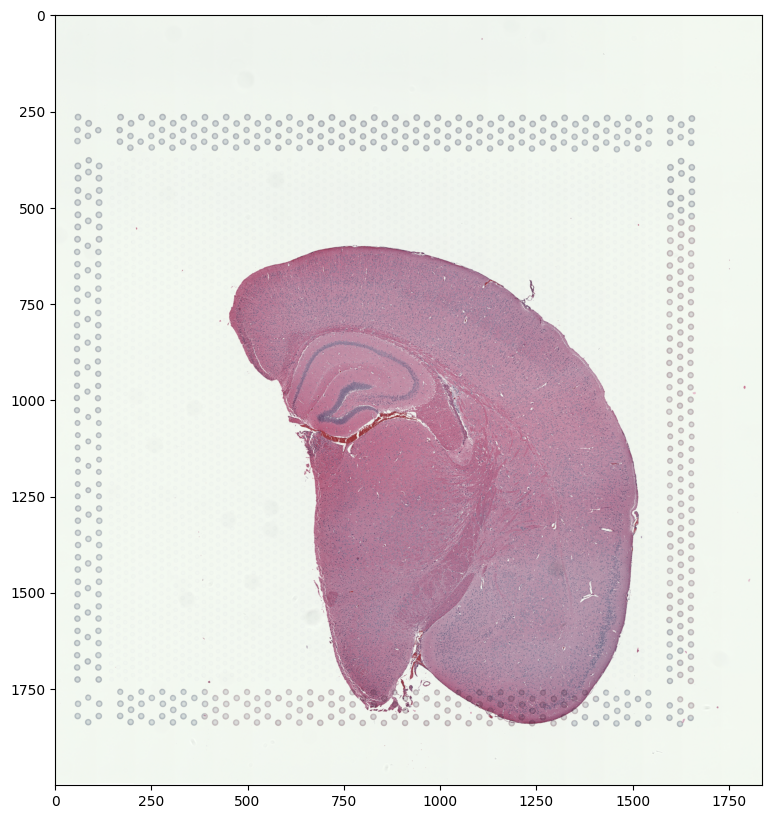

In [8]:
image_file = '../visium_data/tissue_hires_image.png'
V = plt.imread(image_file)

# plot
fig,ax = plt.subplots()
ax.imshow(V)

Note that this is an RGB image that `matplotlib.pyplot` had read in as an NxMx3 matrix with values ranging from 0 to 1. We will use `STalign` to normalize the image in case there are any outlier intensities. 

In [9]:
print("The initial shape of V is {}".format(V.shape))
print("The range of V is {} to {}".format(V.min(), V.max() ))

Vnorm = STalign.normalize(V)
print("The range of V after normalization is {} to {}".format(Vnorm.min(), Vnorm.max() ))

The initial shape of V is (2000, 1838, 3)
The range of V is 0.10588235408067703 to 1.0
The range of V after normalization is 0.0 to 1.0


We will transpose `Vnorm` to be a 3xNxM matrix `J` for downstream analyses. We will also create some variances `YJ` and `XJ` to keep track of the image size. 

In [10]:
J = Vnorm.transpose(2,0,1)
print("The new shape of J is {}".format(J.shape))

YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

The new shape of J is (3, 2000, 1838)


We now have a rasterized image corresponding to the single cell positions from the spatial transcriptomics data and an H&E image that we can align. Note, that we have specified the image from cell positions as source `I` and the H&E image as target `J` because the H&E image is only one hemisphere of the brain. We advise choosing the more complete tissue section as the source such that every observation in the target has some correspondence in the source.

Text(0.5, 1.0, 'target')

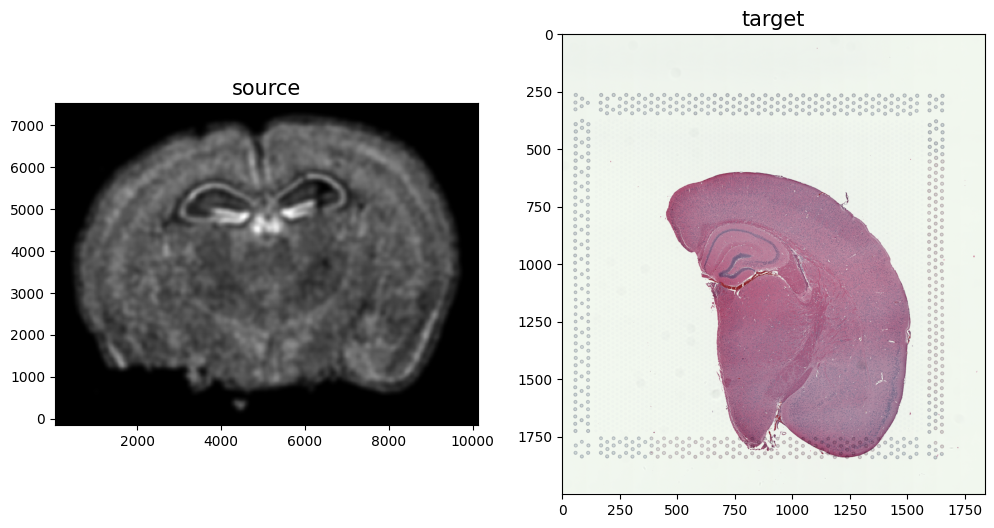

In [11]:
# plot

# get extent of images
extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[0].invert_yaxis()
ax[0].set_title('source', fontsize=15)
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)
ax[1].set_title('target', fontsize=15)

`STalign` relies on an interative gradient descent to align these two images. This can be somewhat slow. So we can manually designate a few landmark points to help initialize the alignment. A `point_annotator.py` script is provided to assist with this. In order to use the `point_annotator.py` script, we will need to write out our images as `.npz` files. 

In [12]:
np.savez('../visium_data/Merfish_S2_R3', x=XI,y=YI,I=I)
np.savez('../visium_data/tissue_hires_image', x=XJ,y=YJ,I=J)

Given these `.npz` files, we can then run the following code on the command line from inside the `notebooks` folder:

```
python ../../STalign/point_annotator.py ../visium_data/Merfish_S2_R3.npz ../visium_data/tissue_hires_image.npz
```

Which will provide a graphical user interface to selecting points. These points will saved as `Merfish_S2_R3_points.npy` and `tissue_hires_image_points.npy` respectively. We can then read in these files. 

In [13]:
# read from file
pointsIlist = np.load('../visium_data/Merfish_S2_R3_points.npy', allow_pickle=True).tolist()
print(pointsIlist)
pointsJlist = np.load('../visium_data/tissue_hires_image_points.npy', allow_pickle=True).tolist()
print(pointsJlist)

{'RSP': [(4972.132324661083, 6736.1086189972975), (5043.667808532049, 5686.921522223103)], 'DG-sg': [(6164.390389177212, 5186.173135126329), (5437.112969822372, 4935.798941577941), (6104.777485951405, 4900.031199642457)], 'CA': [(5127.125873048179, 5066.947328674716), (6080.932324661082, 5794.224748029555), (6915.512969822372, 5269.631199642457)], 'PAA': [(8155.461356919148, 691.3602319005204)], 'MEAav': [(6784.364582725599, 1084.8053931908435)]}
{'RSP': [(450.50172043010843, 769.0582795698929), (563.5486021505385, 940.8025806451617)], 'DG-sg': [(809.2081720430115, 964.7163440860218), (693.9873118279575, 1053.8494623655918), (833.1219354838718, 1034.2836559139787)], 'CA': [(626.5939784946245, 1012.5438709677421), (704.8572043010759, 860.3653763440864), (930.950967741936, 934.2806451612905)], 'PAA': [(1235.307956989248, 1836.4817204301078)], 'MEAav': [(941.8208602150544, 1671.25935483871)]}


Note that these landmark points are read in as lists. We will want to convert them to a simple array for downstream usage. 

In [14]:
# convert to array
pointsI = []
pointsJ = []

for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])
    
pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)

In [15]:
# now arrays
print(pointsI)
print(pointsJ)

[[6736.108619   4972.13232466]
 [5686.92152222 5043.66780853]
 [5186.17313513 6164.39038918]
 [4935.79894158 5437.11296982]
 [4900.03119964 6104.77748595]
 [5066.94732867 5127.12587305]
 [5794.22474803 6080.93232466]
 [5269.63119964 6915.51296982]
 [ 691.3602319  8155.46135692]
 [1084.80539319 6784.36458273]]
[[ 769.05827957  450.50172043]
 [ 940.80258065  563.54860215]
 [ 964.71634409  809.20817204]
 [1053.84946237  693.98731183]
 [1034.28365591  833.12193548]
 [1012.54387097  626.59397849]
 [ 860.36537634  704.8572043 ]
 [ 934.28064516  930.95096774]
 [1836.48172043 1235.30795699]
 [1671.25935484  941.82086022]]


We can double check that our landmark points look sensible by plotting them along with the rasterized image we created.

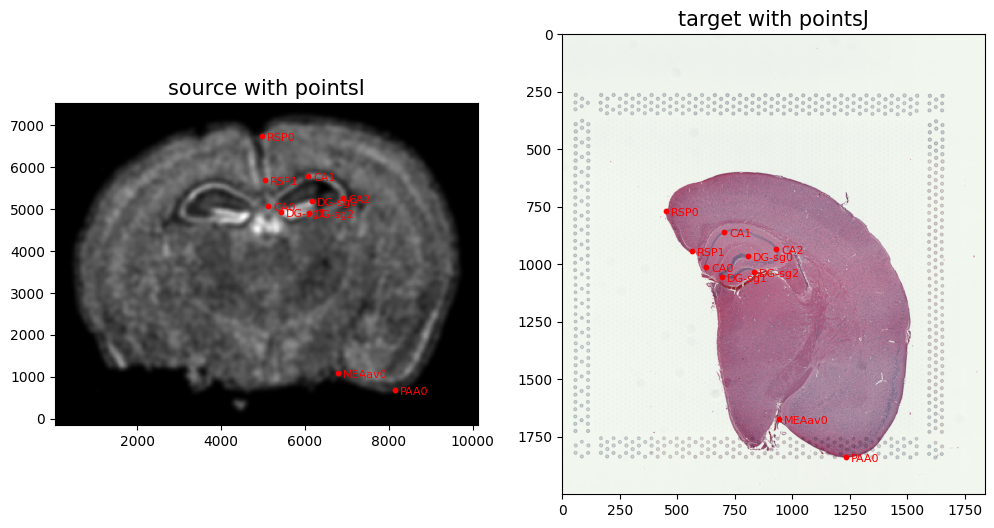

In [16]:
# plot

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red', s=10)
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red', s=10)
    
for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        ax[0].text(pointsIlist[i][j][0], pointsIlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        ax[1].text(pointsJlist[i][j][0], pointsJlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)
        
ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

# invert only rasterized image
ax[0].invert_yaxis()

From the landmark points, we can generate a linear transformation `L` and translation `T` which will produce a simple initial affine transformation `A`. 

In [17]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

In [18]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsI,pointsJ)
A = STalign.to_A(torch.tensor(L),torch.tensor(T))

We can show the results of the simple affine transformation.

/Users/gohtaaihara/.local/share/virtualenvs/STalign-oDkYRjeO/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Text(0.5, 1.0, 'target')

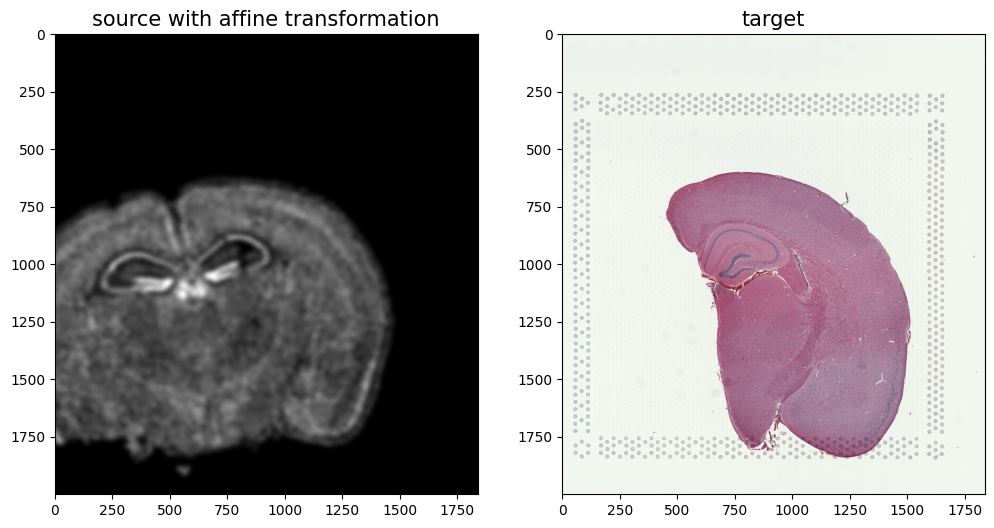

In [19]:
# compute initial affine transformation from points
AI= STalign.transform_image_atlas_with_A(A, [YI,XI], I, [YJ,XJ])

fig,ax = plt.subplots(1,2)

if AI.is_cuda:
    ax[0].imshow((AI.cpu().permute(1,2,0).squeeze()), extent=extentJ) 
else:
    ax[0].imshow((AI.permute(1,2,0).squeeze()), extent=extentJ) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 

ax[0].set_title('source with affine transformation', fontsize=15)
ax[1].set_title('target', fontsize=15)

In this case, we can observe that a simple affine alignment is not sufficient to align the single-cell spatial transcriptomics dataset to the H&E staining image. So we will need to perform non-linear local alignments via LDDMM.

/Users/gohtaaihara/.local/share/virtualenvs/STalign-oDkYRjeO/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/gohtaaihara/Desktop/STalign/docs/notebooks/../../STalign/STalign.py:1301: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')
/Users/gohtaaihara/.local/share/virtualenvs/STalign-oDkYRjeO/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


CPU times: user 36min, sys: 2min 45s, total: 38min 45s
Wall time: 9min 51s


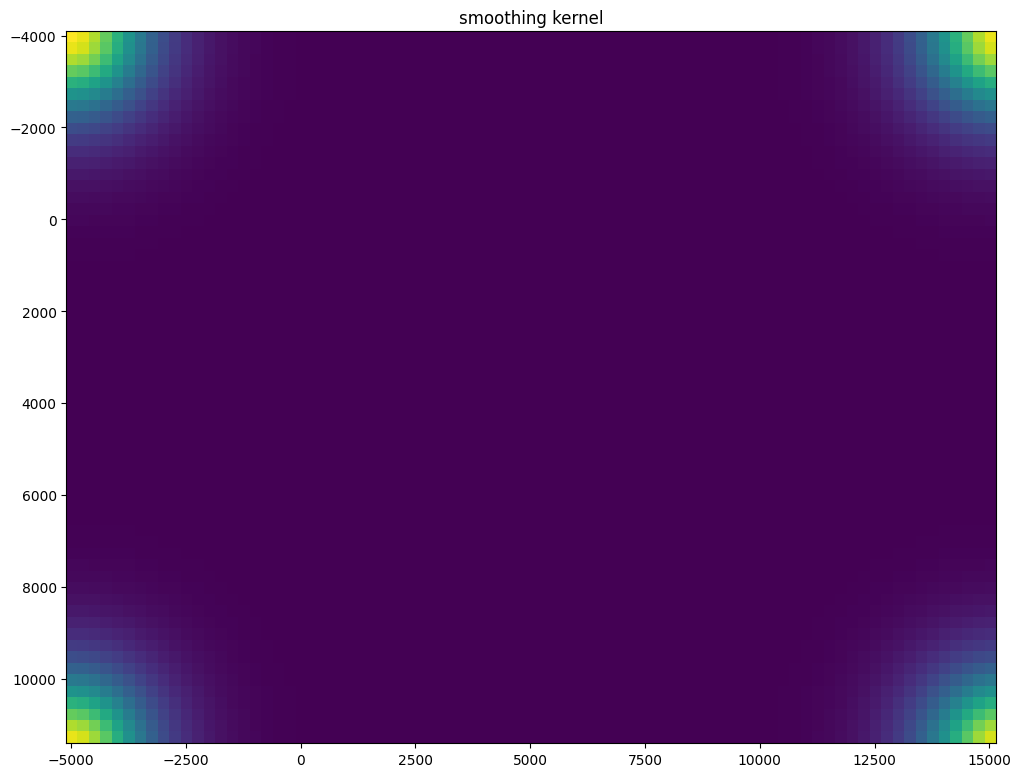

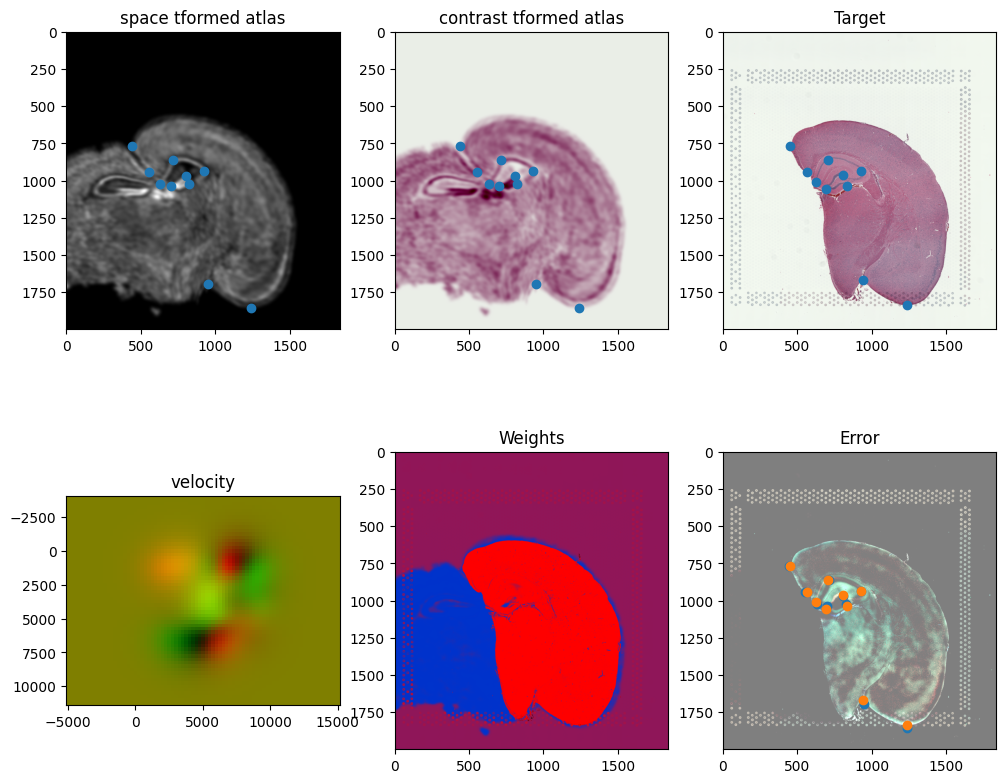

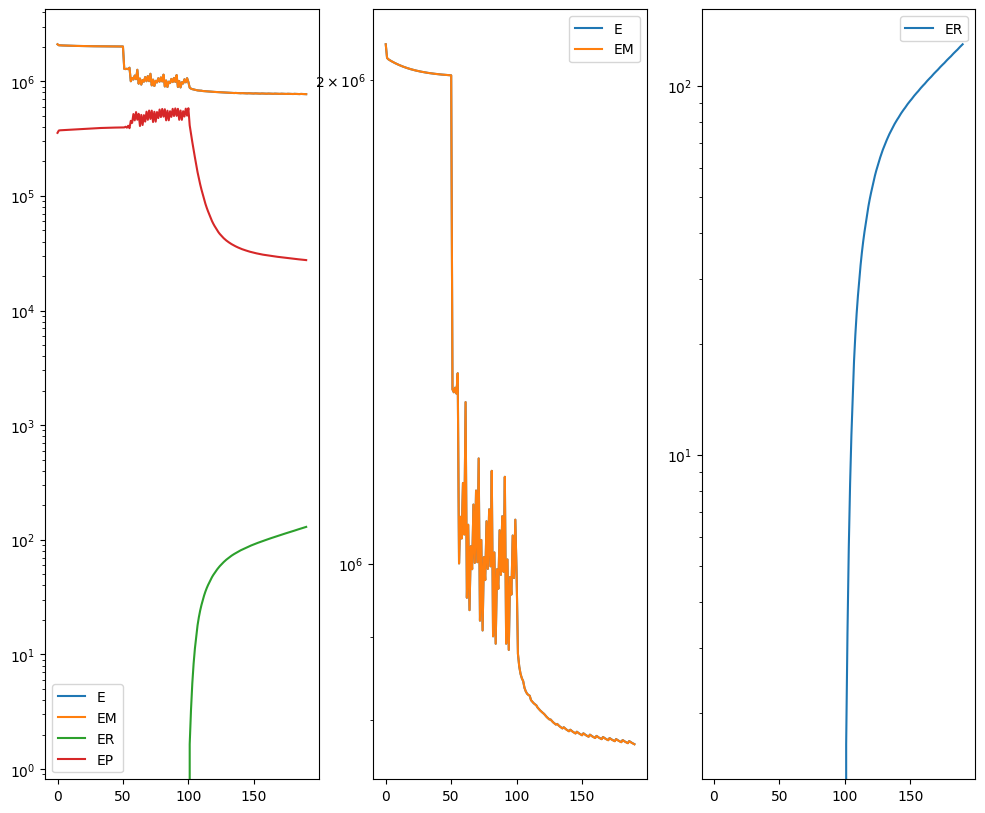

In [20]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {'L':L,'T':T,
          'niter': 200,
          'pointsI': pointsI,
          'pointsJ': pointsJ,
          'device': device,
          'sigmaP': 2e-1,
          'sigmaM': 0.18,
          'sigmaB': 0.18, 
          'sigmaA': 0.18,
          'diffeo_start' : 100,
          'epL': 5e-11,
          'epT': 5e-4,
          'epV': 5e1
          }

out = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

In [21]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']
WM = out['WM']

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

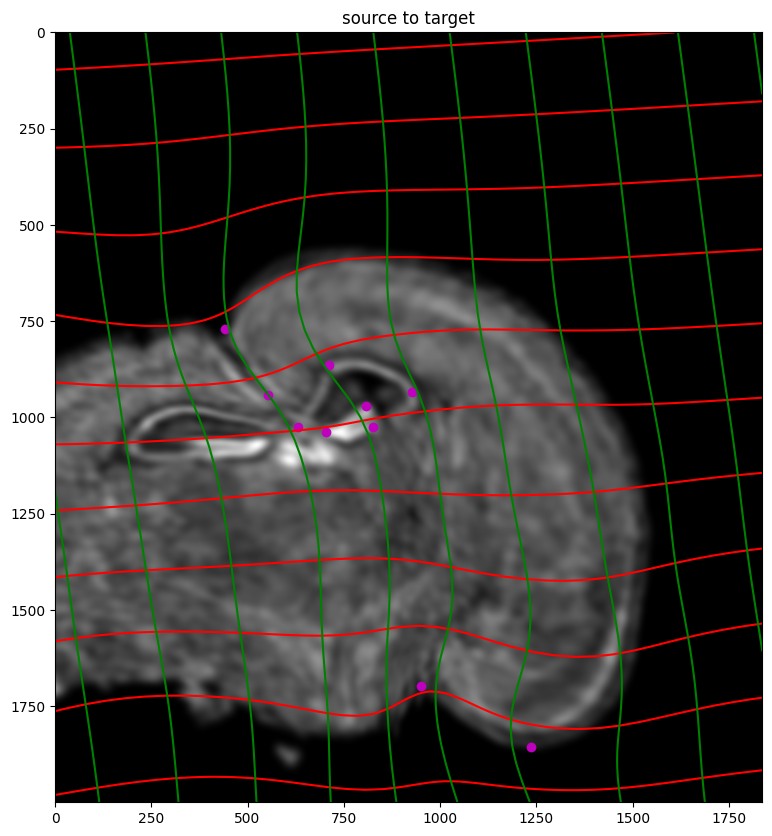

In [22]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_atlas_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
phiipointsI = STalign.transform_points_atlas_to_target(xv,v,A,pointsI)

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)

if phii.is_cuda:
    ax.contour(XJ,YJ,phii[...,0].cpu(),colors='r',linestyles='-',levels=levels)
    ax.contour(XJ,YJ,phii[...,1].cpu(),colors='g',linestyles='-',levels=levels)
else:
    ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
    ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')

if phiI.is_cuda:
    ax.imshow(phiI.cpu().permute(1,2,0)/torch.max(phiI.cpu()),extent=extentJ) 
else:
    ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
    
if phiipointsI.is_cuda:
    ax.scatter(phiipointsI[:,1].cpu().detach(),phiipointsI[:,0].cpu().detach(),c="m")
else:
    ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="m")

Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [23]:
# apply transform to original points
tpointsI= STalign.transform_points_atlas_to_target(xv,v,A, np.stack([yI, xI], 1))

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

And we can visualize the results.

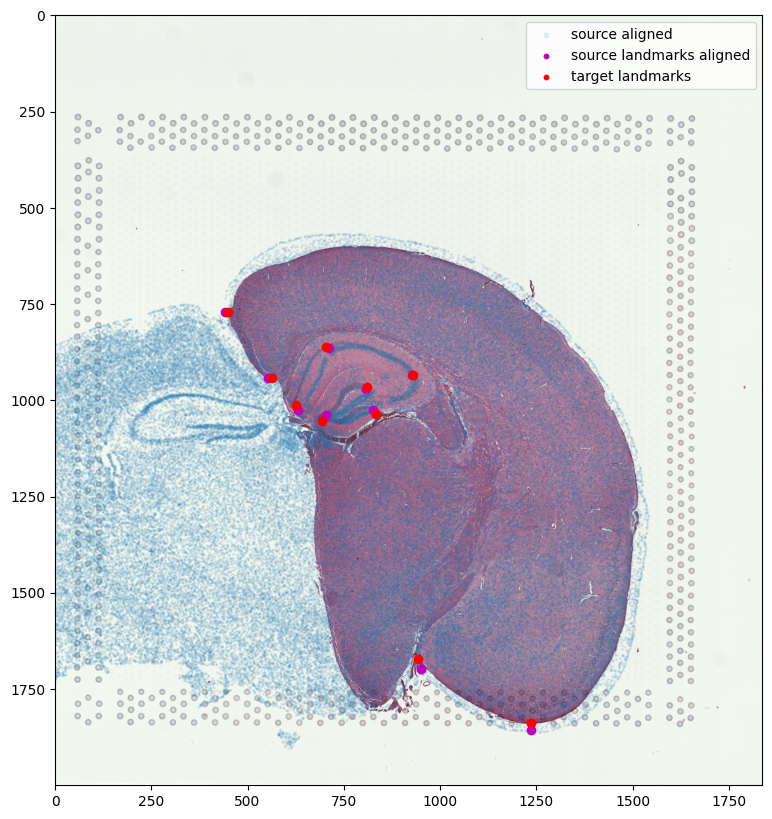

In [24]:
# plot results
fig,ax = plt.subplots()

if tpointsI.is_cuda:
    ax.scatter(xI_LDDMM.cpu(),yI_LDDMM.cpu(),s=1,alpha=0.1, label = 'source aligned')
else:
    ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')

if phiipointsI.is_cuda:
    ax.scatter(phiipointsI[:,1].cpu().detach(),phiipointsI[:,0].cpu().detach(),c="m", label='source landmarks aligned')
else:
    ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="m", label='source landmarks aligned')
    
ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks')
ax.imshow((J).transpose(1,2,0),extent=extentJ)

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])

And save the new aligned positions by appending to our original data

In [25]:
if tpointsI.is_cuda:
    df3 = pd.DataFrame(

        {

            "aligned_x": xI_LDDMM.cpu(),

            "aligned_y": yI_LDDMM.cpu(),

        },


    )
else:
    df3 = pd.DataFrame(

        {

            "aligned_x": xI_LDDMM,

            "aligned_y": yI_LDDMM,

        },


    )    
results = pd.concat([df1, df3], axis=1)
results.head()

Unnamed: 0  fov       volume    center_x  \
0  158338042824236264719696604356349910479   33   532.778772  617.916619   
1  260594727341160372355976405428092853003   33  1004.430016  596.808018   
2  307643940700812339199503248604719950662   33  1267.183208  578.880018   
3   30863303465976316429997331474071348973   33  1403.401822  572.616017   
4  313162718584097621688679244357302162401   33   507.949497  608.364018   

      center_y       min_x       max_x        min_y        max_y   aligned_x  \
0  2666.520010  614.725219  621.108019  2657.545209  2675.494810 -230.977212   
1  2763.450012  589.669218  603.946818  2757.013212  2769.886812 -237.302795   
2  2748.978012  570.877217  586.882818  2740.489211  2757.466812 -240.433165   
3  2766.690012  564.937217  580.294818  2756.581212  2776.798812 -242.056751   
4  2687.418010  603.061218  613.666818  2682.493210  2692.342810 -233.306433   

     aligned_y  
0  1499.746056  
1  1482.881403  
2  1485.901540  
3  1482.865805  
4  1496.236681

We will finally create a compressed `.csv.gz` file named `mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Visium_tissue_hires_image_with_point_annotator.csv.gz`

In [26]:
results.to_csv('../merfish_data/mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Visium_tissue_hires_image_with_point_annotator.csv.gz',
               compression='gzip')

We can also remove background cells in the MERFISH data that did not have a target H&E staining image. Here, we compute weight values for transformed source MERFISH points from target H&E image pixel locations and weight 2D array (matching). We then use the computed weight values and a manually selected threshold to remove background cells.

In [27]:
# create a list storing the pixel locations of J along each imagea axis in row column order
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
dtype=torch.float64

dJ = 1.0 # just pixels, no origin
rowcol_J = [torch.arange(J.shape[1],device=device,dtype=dtype)*dJ - (J.shape[1]-1)*dJ/2.0*0,
      torch.arange(J.shape[2],device=device,dtype=dtype)*dJ - (J.shape[2]-1)*dJ/2.0*0]
rowcol_J

[tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.9970e+03, 1.9980e+03,
         1.9990e+03], dtype=torch.float64),
 tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.8350e+03, 1.8360e+03,
         1.8370e+03], dtype=torch.float64)]

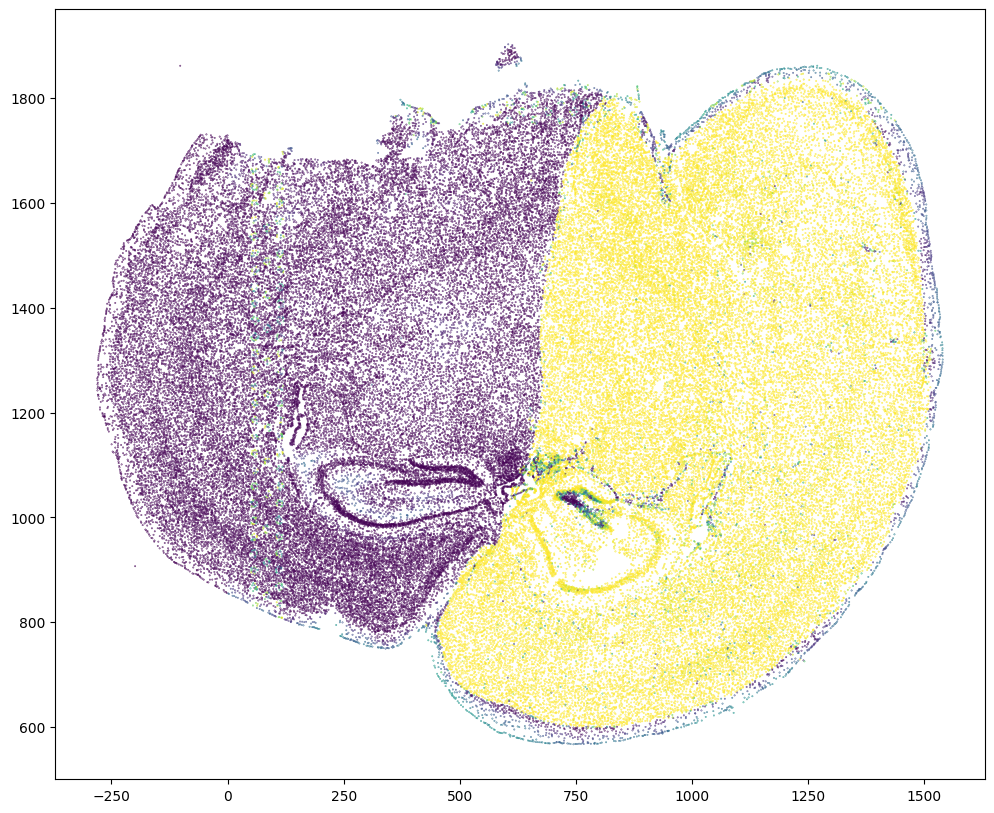

In [28]:
# compute weight values for transformed source points from target image pixel locations and weight 2D array (matching) 
testM = STalign.interp(rowcol_J,WM[None].float(),tpointsI[None].permute(-1,0,1).float())
fig,ax = plt.subplots()
ax.scatter(tpointsI[:,1],tpointsI[:,0],c=testM[0,0],s=0.1,vmin=0,vmax=1)

In [29]:
# save weight values
results['WM_values'] = testM[0,0]

In [30]:
results

Unnamed: 0   fov       volume  \
0      158338042824236264719696604356349910479    33   532.778772   
1      260594727341160372355976405428092853003    33  1004.430016   
2      307643940700812339199503248604719950662    33  1267.183208   
3       30863303465976316429997331474071348973    33  1403.401822   
4      313162718584097621688679244357302162401    33   507.949497   
...                                        ...   ...          ...   
85953  311704042603434891559886168438769992293  1545  1625.490809   
85954  312851880059098327776181257829209599759  1545   905.032435   
85955  332299915869590281339501510603978852698  1545   459.647325   
85956  150462787759670321084458536479486602685  1546   778.386670   
85957  268870416870774615427277589169474700725  1546   592.088115   

          center_x     center_y        min_x        max_x        min_y  \
0       617.916619  2666.520010   614.725219   621.108019  2657.545209   
1       596.808018  2763.450012   589.669218   603.946818  2757.013212   
2       578.880018  2748.978012   570.877217   586.882818  2740.489211   
3       572.616017  2766.690012   564.937217   580.294818  2756.581212   
4       608.364018  2687.418010   603.061218   613.666818  2682.493210   
...            ...          ...          ...          ...          ...   
85953  9623.123579  4030.182069  9615.660779  9630.586379  4019.749269   
85954  9625.067579  4008.749469  9620.088779  9630.046379  4000.320068   
85955  9605.470978  4187.268073  9600.767578  9610.174378  4182.397273   
85956  9606.874978  4208.819338  9600.767578  9612.982378  4200.335938   
85957  9607.841578  4219.019938  9602.700778  9612.982378  4213.393138   

             max_y    aligned_x    aligned_y  WM_values  
0      2675.494810  -230.977212  1499.746056   0.000000  
1      2769.886812  -237.302795  1482.881403   0.000000  
2      2757.466812  -240.433165  1485.901540   0.000000  
3      2776.798812  -242.056751  1482.865805   0.000000  
4      2692.342810  -233.306433  1496.236681   0.000000  
...            ...          ...          ...        ...  
85953  4040.614869  1518.257673  1172.747197   0.391967  
85954  4017.178869  1519.238502  1177.403748   0.351259  
85955  4192.138873  1509.707181  1138.817210   0.404441  
85956  4217.302738  1509.207672  1134.097519   0.409148  
85957  4224.646738  1509.027803  1131.858933   0.377325  

[85958 rows x 12 columns]

(array([39911.,   996.,   549.,   453.,   396.,   374.,   395.,   314.,
          233.,   261.,   185.,   170.,   138.,   197.,   218.,   218.,
          287.,   379.,   744., 39540.]),
 array([0.        , 0.04999989, 0.09999979, 0.14999968, 0.19999957,
        0.24999946, 0.29999936, 0.34999925, 0.39999914, 0.44999903,
        0.49999893, 0.54999882, 0.59999871, 0.64999861, 0.6999985 ,
        0.74999839, 0.79999828, 0.84999818, 0.89999807, 0.94999796,
        0.99999785]),
 <BarContainer object of 20 artists>)

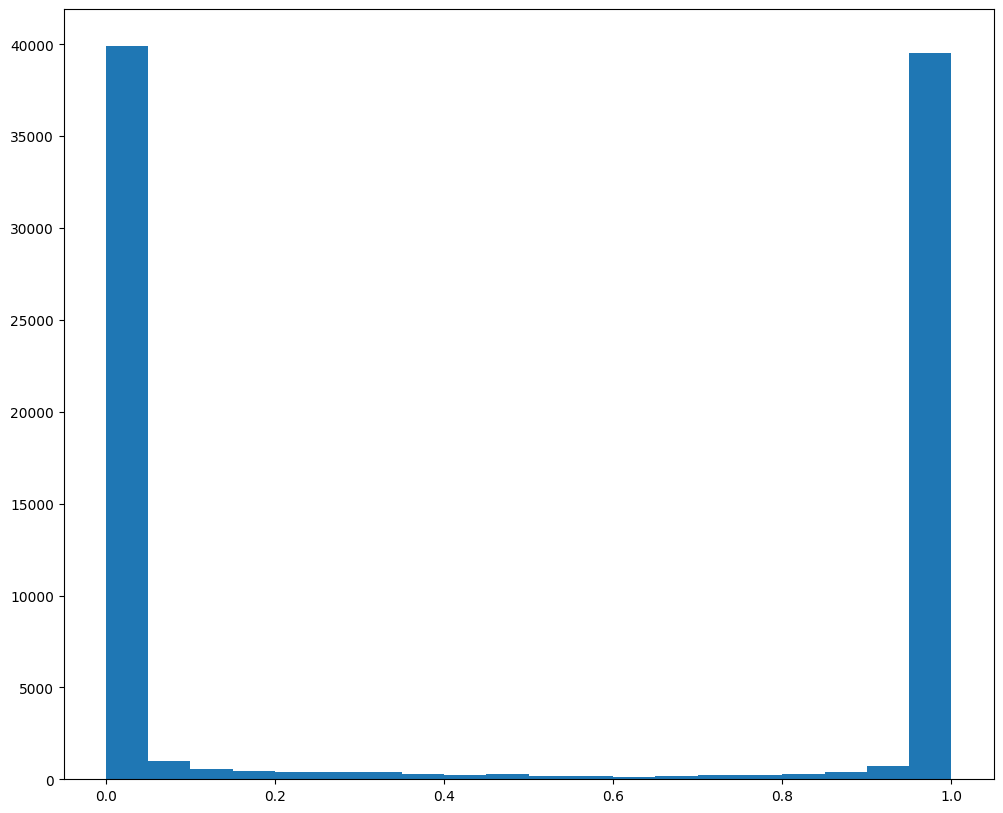

In [31]:
fig,ax = plt.subplots()
ax.hist(results['WM_values'], bins = 20)

Based on this distribution and manual inspection, we can manually set a threshold value to filter transformed MERFISH data.

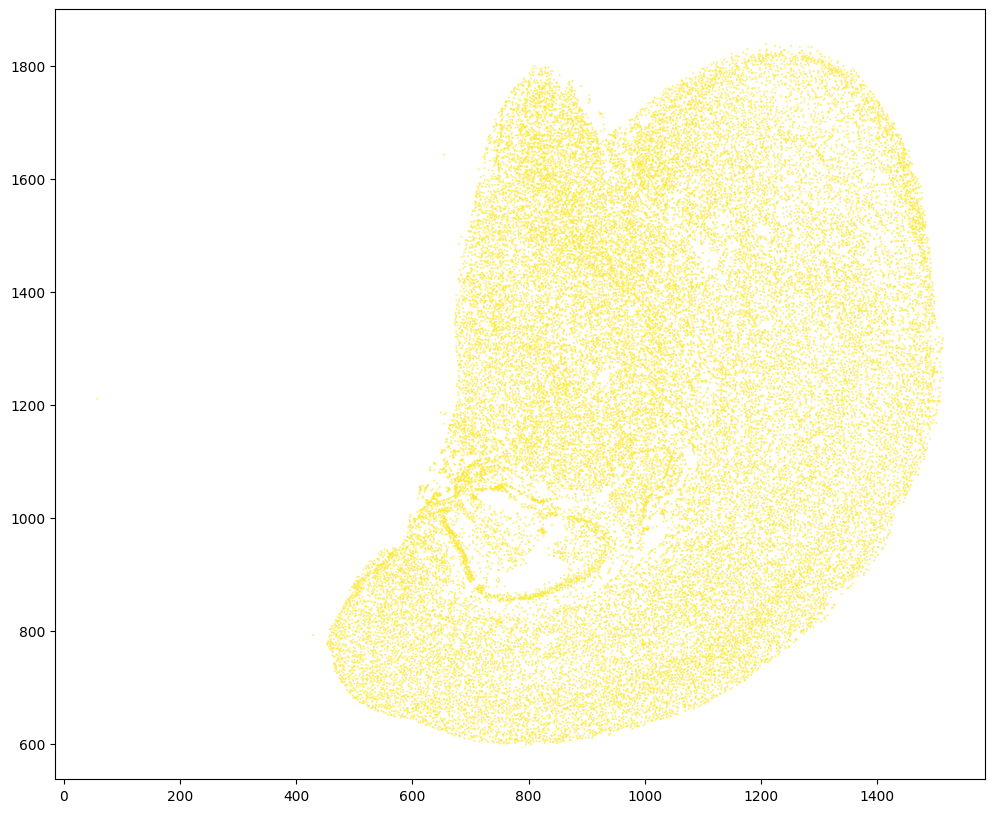

In [34]:
# set a threshold value
WMthresh = 0.98

# filter transformed MERFISH data
results_filtered = results[results['WM_values'] > WMthresh]

# plot
fig,ax = plt.subplots()
ax.scatter(results_filtered['aligned_x'],results_filtered['aligned_y'],c=results_filtered['WM_values'],s=0.1,vmin=0,vmax=1)
plt.show()

Similar to the unfiltered dataset, create a compressed `.csv.gz` file named `mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Slice2_Replicate2_STalign_to_Visium_tissue_hires_image_with_point_annotator_filtered.csv.gz`

In [35]:
results.to_csv('../merfish_data/mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Slice2_Replicate2_STalign_to_Visium_tissue_hires_image_with_point_annotator_filtered.csv.gz',
               compression='gzip')